# Étude de l'erreur due à la diffusion et à la convection dans le cas du SWARM

In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), '..'))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path

In [2]:
from src.main import *
from src.plot_fields import *

%matplotlib inline
rc('figure', figsize=(10,5))
rc('figure', dpi=100)

## Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en WENO avec Euler explicite en temps.

In [3]:
Formulation = [Problem]
phy_prop = PhysicalProperties(Delta=0.02, v=0.2, dS=0.005**2,
                                  lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=1.,
                                  alpha=0.06, a_i=357.)
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno', time_scheme='rk4', phy_prop=phy_prop, cfl=0.5, fo=1.)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)

## Étude selon la formulation de l'équation

En fait s'il n'y a pas de convection il n'y a pas de différence entre les différentes formes, à l'exception de la moyenne utilisée pour $\frac{1}{\rho C_p}$

### RK4

dt fourier
6.918433404737903e-06
mixte dE*/dt* = -0.000004


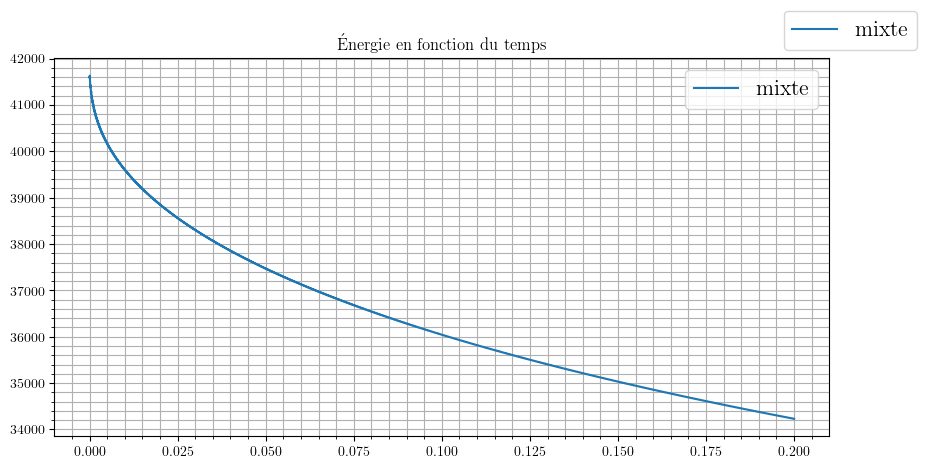

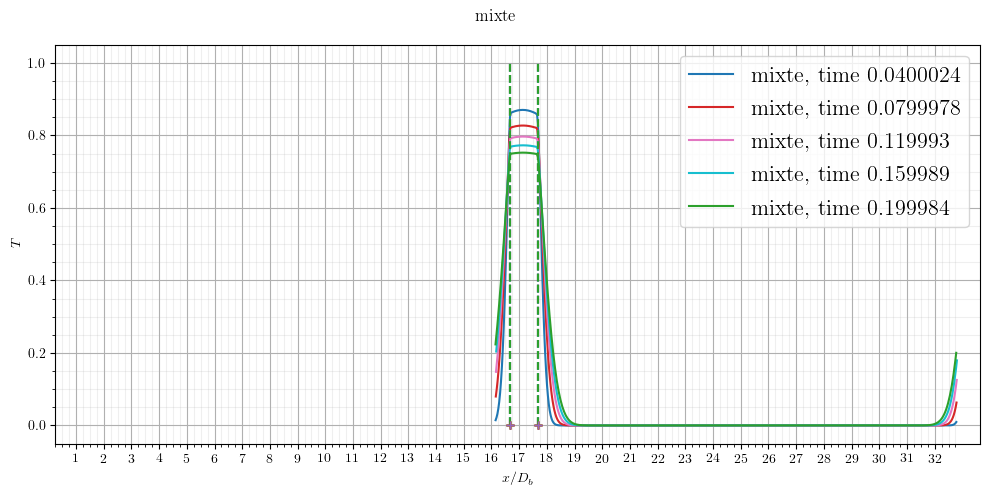

In [4]:
fig1,ax1 = plt.subplots(1)
ax1.set_title('Énergie en fonction du temps')
# fig2, ax2 = plt.subplots(1)
# ax2.set_title('Énergie adimensionnée en fonction du temps adim')
for form in Formulation:
    # x, T = get_T_creneau(dx=dx, Delta=Delta, markers=markers)
    # T = T + 1.
    prob = form(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
    E0 = prob.energy
    t, e = prob.timestep(t_fin=0.2, number_of_plots=5, debug=None, plotter=Plotter('decale'))
    l = ax1.plot(t, e/(0.02*0.005**2), label=prob.name)
    ax1.legend()
    n = len(e)
    i0 = int(n/5)
    # ax2.plot(t/prob.dt, e / E0, label=prob.name)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print(prob.name, 'dE*/dt* = %f' % dedt_adim)
le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which='major')
ax1.grid(b=True, which='minor', alpha=0.2)

### Euler

In [5]:
Formulation = [Problem, ProblemConserv2]
phy_prop = PhysicalProperties(Delta=0.02, v=0.2, dS=0.005**2,
                                  lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=1.,
                                  alpha=0.06, a_i=357.)
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno', time_scheme='euler', phy_prop=phy_prop, cfl=0.5, fo=1.)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)

dt fourier
6.918433404737903e-06
mixte dE*/dt* = -0.000001


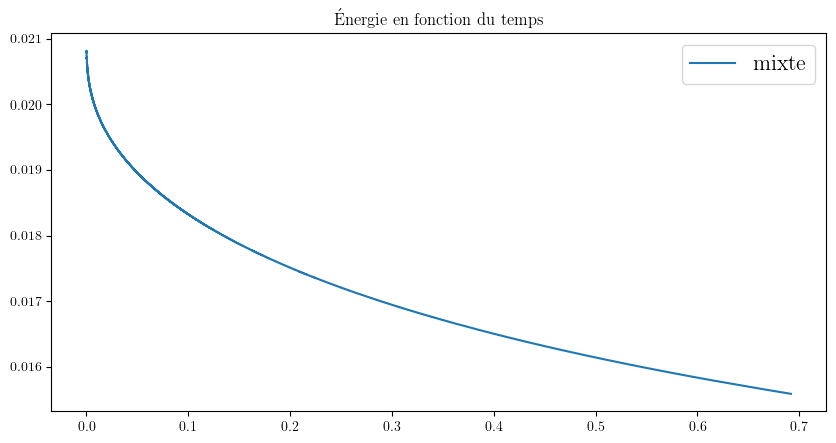

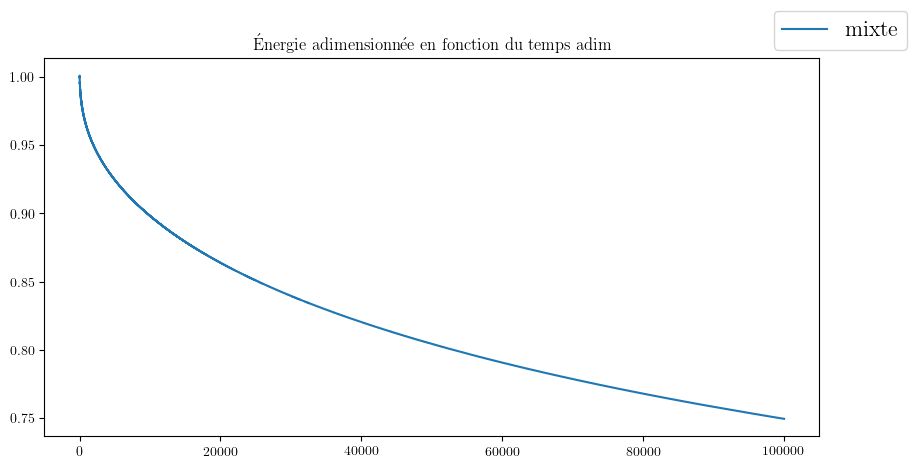

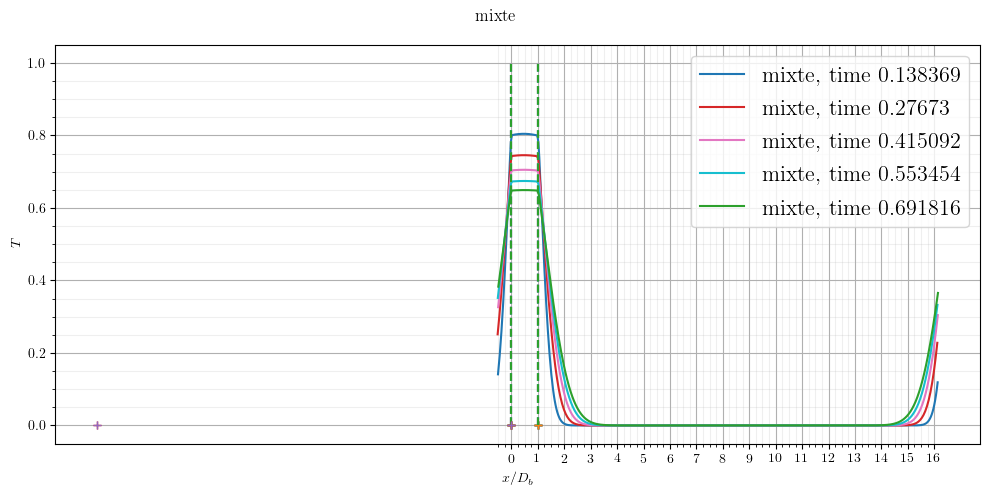

In [7]:
fig1,ax1 = plt.subplots(1)
ax1.set_title('Énergie en fonction du temps')
fig2, ax2 = plt.subplots(1)
ax2.set_title('Énergie adimensionnée en fonction du temps adim')
for form in Formulation:
    prob = form(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
    E0 = prob.energy
    t, e = prob.timestep(n=100000, number_of_plots=5, debug=None, plotter=Plotter('decale'))
    l = ax1.plot(t, e, label=prob.name)
    ax1.legend()
    n = len(e)
    i0 = int(n/5)
    ax2.plot(t/prob.dt, e / E0, label=prob.name)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print(prob.name, 'dE*/dt* = %f' % dedt_adim)
le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which='major')
ax1.grid(b=True, which='minor', alpha=0.2)
le = fig2.legend()
ax2.minorticks_on()
ax2.grid(b=True, which='major')
ax2.grid(b=True, which='minor', alpha=0.2)

## Cas boniou, euler avec weno et upwind quand le stencil traverse l'interface

In [10]:
Formulation = [Problem, ProblemConserv2]
phy_prop = PhysicalProperties(Delta=0.02, v=0.2, dS=0.005**2,
                                  lda1=5.5*10**-2, lda2=15.5, rho_cp1=70278., rho_cp2=702780., diff=1.,
                                  alpha=0.06, a_i=357.)
num_prop = NumericalProperties(dx=3.9*10**-5, schema='weno upwind', time_scheme='euler', phy_prop=phy_prop, cfl=0.5, fo=1.)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)

dt fourier
6.918433404737903e-06
mixte dE*/dt* = -0.000002
dt fourier
6.918433404737903e-06
EC, mixte dE*/dt* = 0.000001


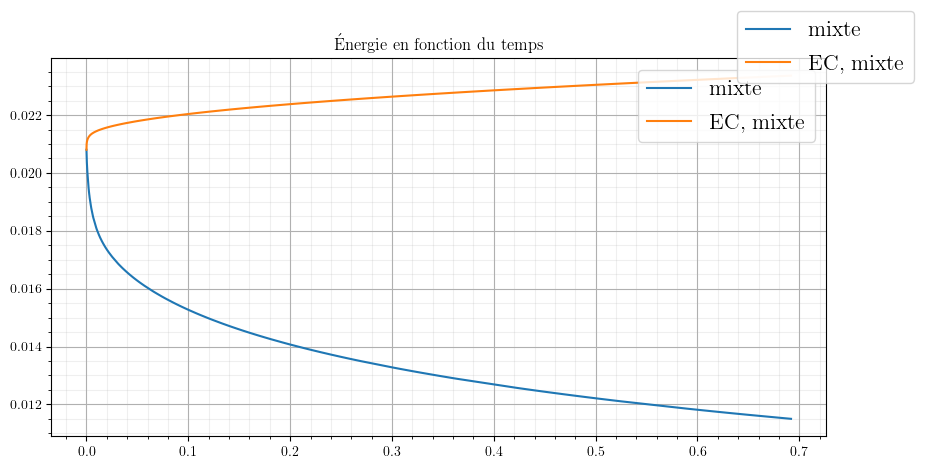

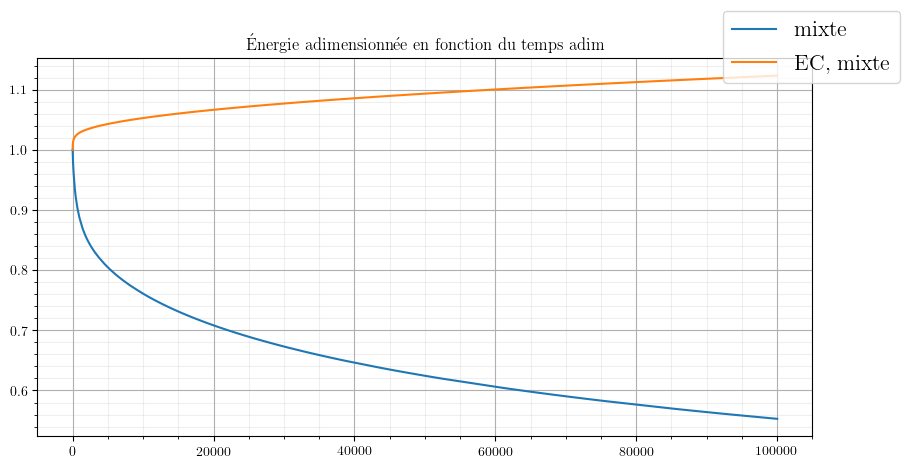

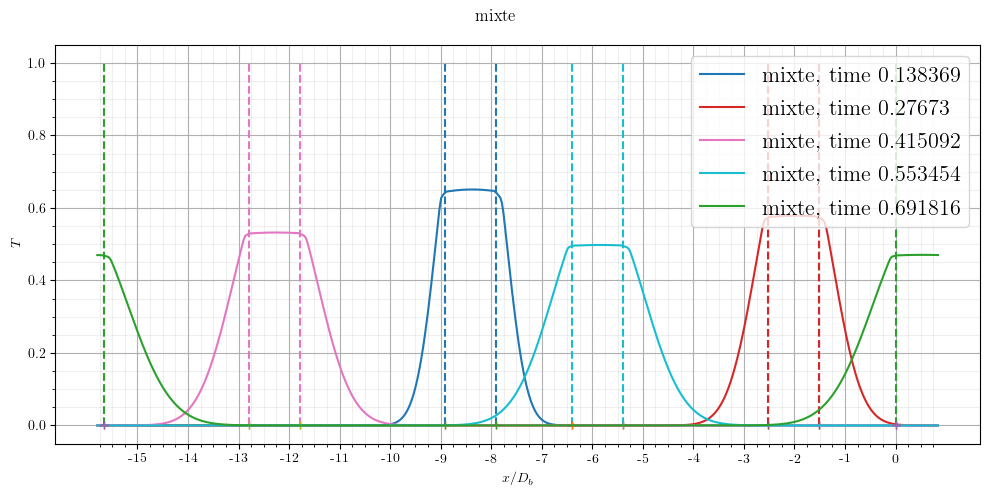

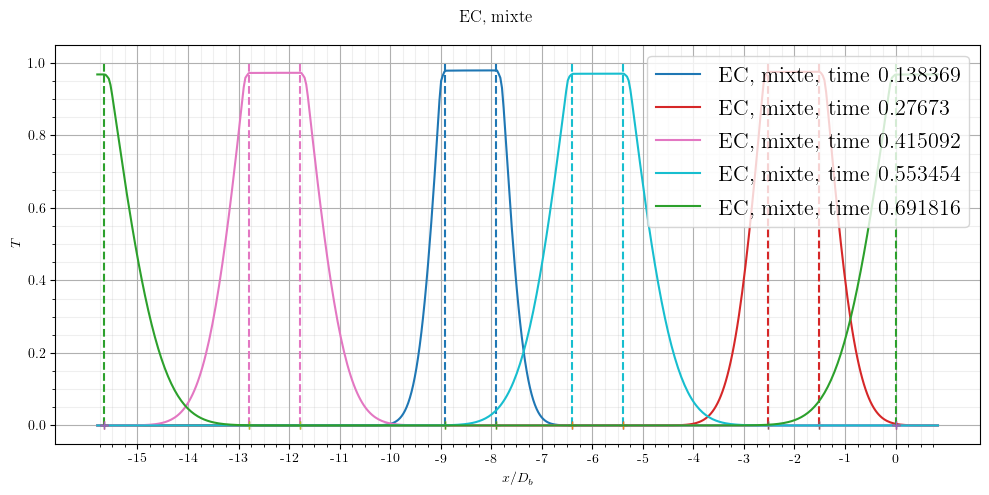

In [11]:
fig1,ax1 = plt.subplots(1)
ax1.set_title('Énergie en fonction du temps')
fig2, ax2 = plt.subplots(1)
ax2.set_title('Énergie adimensionnée en fonction du temps adim')
for form in Formulation:
    prob = form(get_T_creneau, phy_prop=phy_prop, num_prop=num_prop, markers=markers)
    E0 = prob.energy
    t, e = prob.timestep(n=100000, number_of_plots=5, debug=None, plotter=Plotter('classic'))
    l = ax1.plot(t, e, label=prob.name)
    ax1.legend()
    n = len(e)
    i0 = int(n/5)
    ax2.plot(t/prob.dt, e / E0, label=prob.name)
    dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
    # par Dt / rho_cp_l T_l V
    print(prob.name, 'dE*/dt* = %f' % dedt_adim)
le = fig1.legend()
ax1.minorticks_on()
ax1.grid(b=True, which='major')
ax1.grid(b=True, which='minor', alpha=0.2)
le = fig2.legend()
ax2.minorticks_on()
ax2.grid(b=True, which='major')
ax2.grid(b=True, which='minor', alpha=0.2)